##Importing Necessary Libraries

In [77]:
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
import itertools
from collections import Counter
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

##Preparation and reading data

In [78]:
def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''

    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }

    with open(file, 'r', encoding='utf-8') as raw_data:
        # print(raw_data.read())
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns

        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df

    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])

    # split user and msg
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("group_notification")
            msgs.append(a[0])

    # creating new columns
    df['user'] = usernames
    df['message'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)

    return df

In [79]:
df = rawToDf('/content/WhatsApp Chat with Kirak Boyz.txt', '12hr')
df

,date_time,user,message
0,2024-07-15 20:30:00,group_notification,Messages and calls are end-to-end encrypted. O...
1,2024-07-15 20:40:00,Mani Kalyan Sc,😂😂😂😂😂
2,2024-07-15 20:41:00,Mani Kalyan Sc,Reyy nenu pettaledhu ra
3,2024-07-15 20:41:00,Mani Kalyan Sc,Ma frnd petti dengadu
4,2024-07-15 20:41:00,Mani Kalyan Sc,🥲🥲🥲🥲
...,...,...,...
7681,2025-10-20 09:51:00,Anvesh Sc,I'm looking for a bonus tick. If you have the ...
7682,2025-10-20 09:52:00,Anvesh Sc,Happieee diwali prendssss🪔🎇🎇
7683,2025-10-20 09:55:00,Syam Sai Sc,Happy Diwali 🪔
7684,2025-10-21 09:49:00,Shiva,#BaahubaliTheEpic AP/TG Rights Ratio Nizam - ...


##Pre-Processing

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7686 entries, 0 to 7685
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  7686 non-null   datetime64[ns]
 1   user       7686 non-null   object        
 2   message    7686 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 180.3+ KB


In [81]:
df.sample(10)

,date_time,user,message
1680,2024-10-13 09:43:00,Sarath Sc,<Media omitted>
6252,2025-03-24 23:24:00,Syam Sai Sc,Aah
3719,2024-11-16 00:06:00,Koushik Sharma Sc,<Media omitted>
2106,2024-10-20 00:16:00,Koushik Sharma Sc,Odiyamma ipl lo kuda ide performance istadu ay...
3593,2024-11-10 16:17:00,Syam Sai Sc,bhAAi tho kabatti untai
6546,2025-05-31 22:40:00,Prem Sai Sc,Thanks ra @⁨Pramodh SC⁩ ❤️
4631,2024-11-27 10:26:00,Syam Sai Sc,<Media omitted>
7630,2025-10-08 21:31:00,Anvesh Sc,Ahaaa
3513,2024-11-05 20:11:00,Mani Kalyan Sc,Adhey le
4545,2024-11-25 19:59:00,Koushik Sharma Sc,😂 le


In [82]:
df[df['message'] == ""].shape[0]

68

In [83]:
#Adding extra helper columns for analysis and visualization
df['day'] = df['date_time'].dt.strftime('%a')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())

In [84]:
#Final Data Frame
df

,date_time,user,message,day,month,year,date
0,2024-07-15 20:30:00,group_notification,Messages and calls are end-to-end encrypted. O...,Mon,Jul,2024,2024-07-15
1,2024-07-15 20:40:00,Mani Kalyan Sc,😂😂😂😂😂,Mon,Jul,2024,2024-07-15
2,2024-07-15 20:41:00,Mani Kalyan Sc,Reyy nenu pettaledhu ra,Mon,Jul,2024,2024-07-15
3,2024-07-15 20:41:00,Mani Kalyan Sc,Ma frnd petti dengadu,Mon,Jul,2024,2024-07-15
4,2024-07-15 20:41:00,Mani Kalyan Sc,🥲🥲🥲🥲,Mon,Jul,2024,2024-07-15
...,...,...,...,...,...,...,...
7681,2025-10-20 09:51:00,Anvesh Sc,I'm looking for a bonus tick. If you have the ...,Mon,Oct,2025,2025-10-20
7682,2025-10-20 09:52:00,Anvesh Sc,Happieee diwali prendssss🪔🎇🎇,Mon,Oct,2025,2025-10-20
7683,2025-10-20 09:55:00,Syam Sai Sc,Happy Diwali 🪔,Mon,Oct,2025,2025-10-20
7684,2025-10-21 09:49:00,Shiva,#BaahubaliTheEpic AP/TG Rights Ratio Nizam - ...,Tue,Oct,2025,2025-10-21


#Data Analysis

##Overall frequency of total messages on the group.

In [85]:
df1 = df.copy()      # I will be using a copy of the original data frame everytime, to avoid loss of data!
df1['message_count'] = [1] * df1.shape[0]      # adding extra helper column --> message_count.
df1.drop(columns='year', inplace=True)         # dropping unnecessary columns, using `inplace=True`, since this is copy of the DF and won't affect the original DataFrame.
df1 = df1.groupby('date')['message_count'].sum().reset_index()  # grouping by date; since plot is of frequency of messages --> no. of messages / day.
df1

,date,message_count
0,2024-07-15,49
1,2024-07-16,76
2,2024-07-17,2
3,2024-07-18,65
4,2024-07-19,7
...,...,...
357,2025-10-17,2
358,2025-10-18,7
359,2025-10-19,18
360,2025-10-20,7


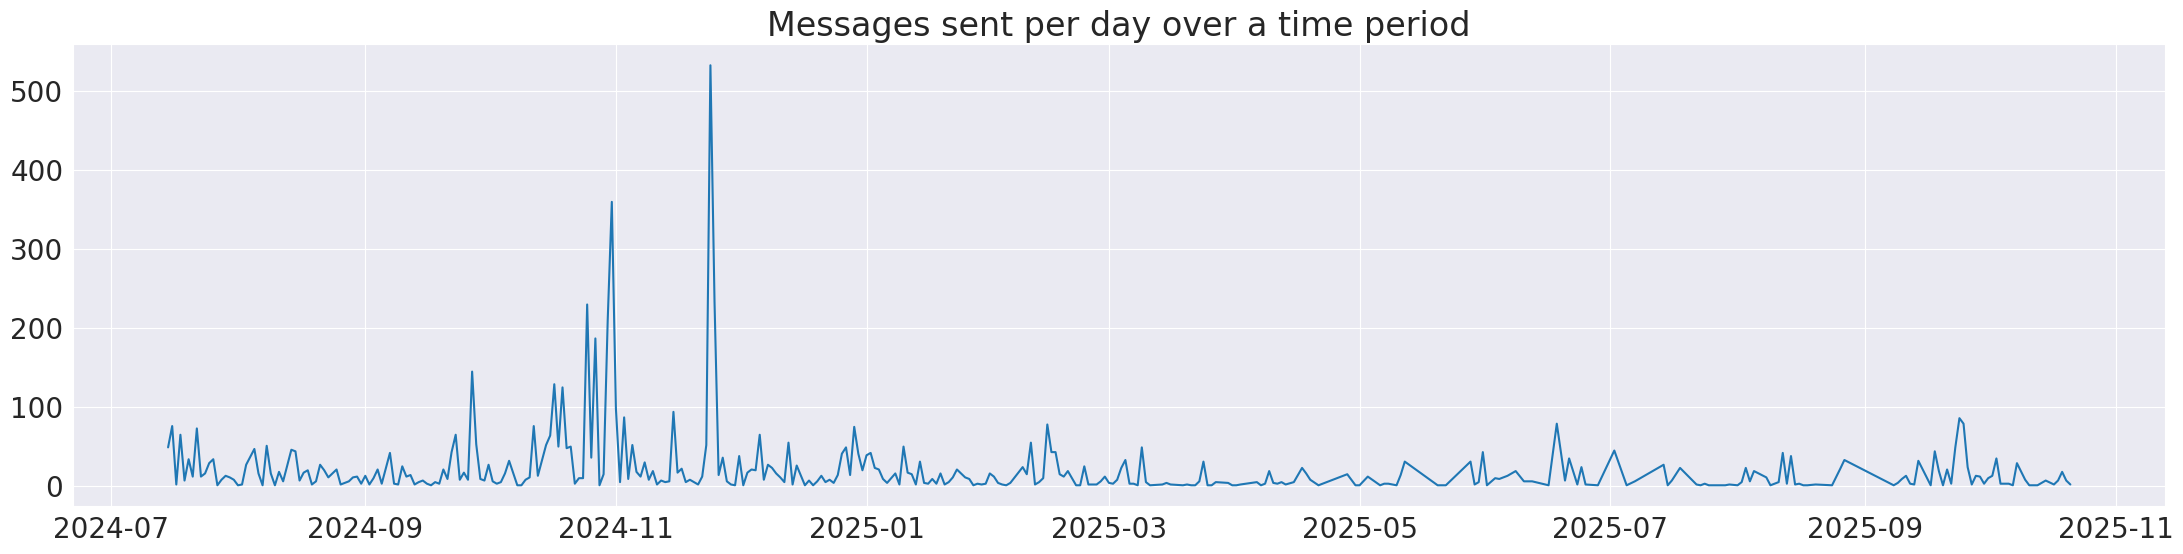

In [86]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (27, 6)


# A basic plot
plt.plot(df1.date, df1.message_count)
plt.title('Messages sent per day over a time period');

# Could have used Seaborn's lineplot as well.
# sns.lineplot(df1.date, df1.message_count);


# Saving the plots
plt.savefig('msg_plots.svg', format = 'svg')

##Top 10 most active days.

In [87]:
top10days = df1.sort_values(by="message_count", ascending=False).head(10)    # Sort values according to the number of messages per day.
top10days.reset_index(inplace=True)           # reset index in order.
top10days.drop(columns="index", inplace=True) # dropping original indices.
top10days

,date,message_count
0,2024-11-24,533
1,2024-10-31,360
2,2024-11-25,233
3,2024-10-25,230
4,2024-10-30,210
5,2024-10-27,187
6,2024-09-27,145
7,2024-10-17,129
8,2024-10-19,125
9,2024-11-01,98


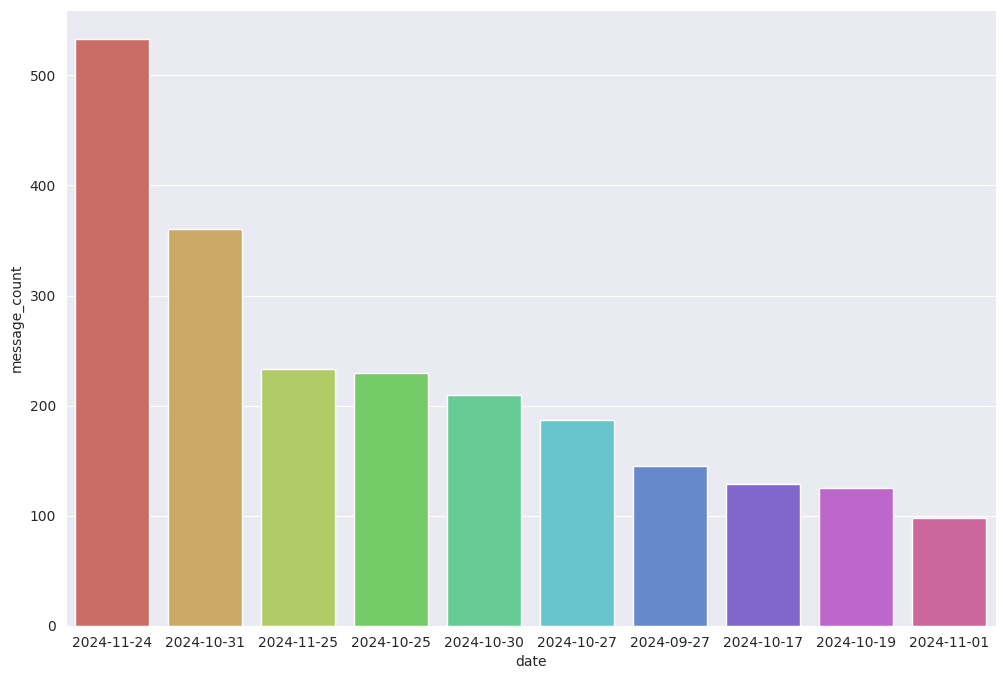

In [88]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (12, 8)

# A bar plot for top 10 days
sns.barplot(x=top10days.date, y=top10days.message_count, palette="hls");

# Saving the plots
plt.savefig('top10_days.svg', format = 'svg')

##Top 10 active users on the group.

In [89]:
# Total number of people who have sent at least one message on the group;
print(f"Total number of people who have sent at least one message on the group are {len(df.user.unique()) - 1}")   # `-1` because excluding "group_notficiation"

print(f"Number of people who haven't sent even a single message on the group are {92 - len(df.user.unique()) - 1}")

Total number of people who have sent at least one message on the group are 62
Number of people who haven't sent even a single message on the group are 28


Total number of people who have sent at least one message on the group are 62.

BUT, the total number of participants were 92.

That means 28 people in the group have not sent even a single message


##pre-processing top 10 active users.

In [90]:
df2 = df.copy()
df2 = df2[df2.user != "group_notification"]
top10df = df2.groupby("user")["message"].count().sort_values(ascending=False)

# Final Data Frame
top10df = top10df.head(10).reset_index()
top10df


,user,message
0,Syam Sai Sc,1934
1,Shiva,1242
2,Pavan Sai Sc,594
3,Gunasai Sc,574
4,Sarath Sc,489
5,Koushik Sharma Sc,420
6,Anvesh Sc,408
7,Mani Kalyan Sc,210
8,Chaitanya Sai Sc,205
9,Revanth Sc,154


##Visualizing top 10 active users

In [91]:
top10df['initials'] = ''
for i in range(10):
    name_parts = top10df.user[i].split()
    if len(name_parts) > 1:
        top10df.initials[i] = name_parts[0][0] + name_parts[1][0]
    else:
        top10df.initials[i] = name_parts[0][:2]

top10df.initials[1] = "Me"    # That's me
top10df.initials[4]="SA"

In [92]:
# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

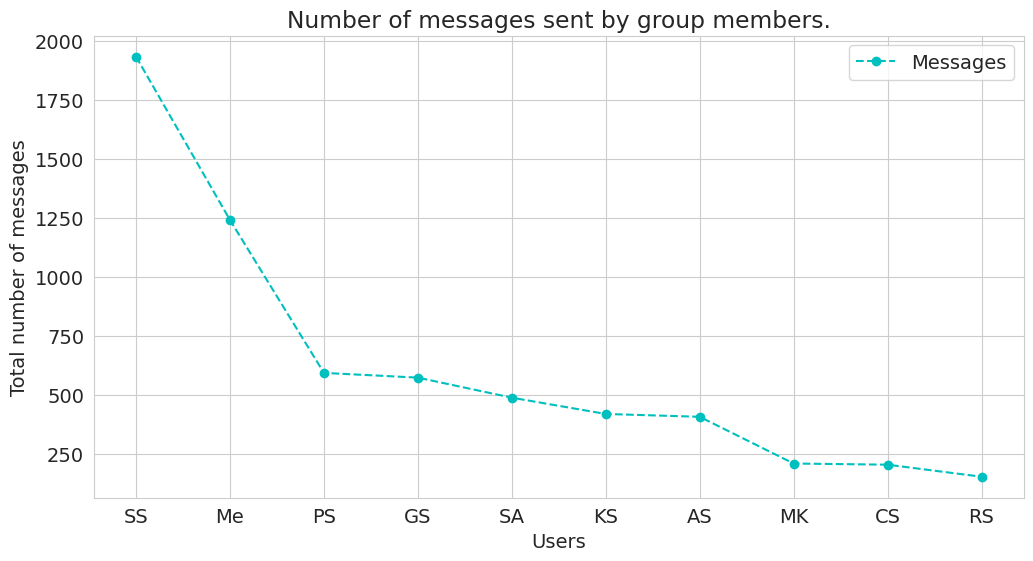

In [93]:
#Plotting a simple line graph.
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))


# plt.plot(top10df.initials, top10df.message, marker='o', ls='--', c='cyan')

# BETTER IMPLEMENTATION using the `fmt` argument;
plt.plot(top10df.initials, top10df.message, 'o--c')


# Labels and Title
plt.xlabel('Users')
plt.ylabel('Total number of messages')

plt.title("Number of messages sent by group members.")
plt.legend(['Messages']);


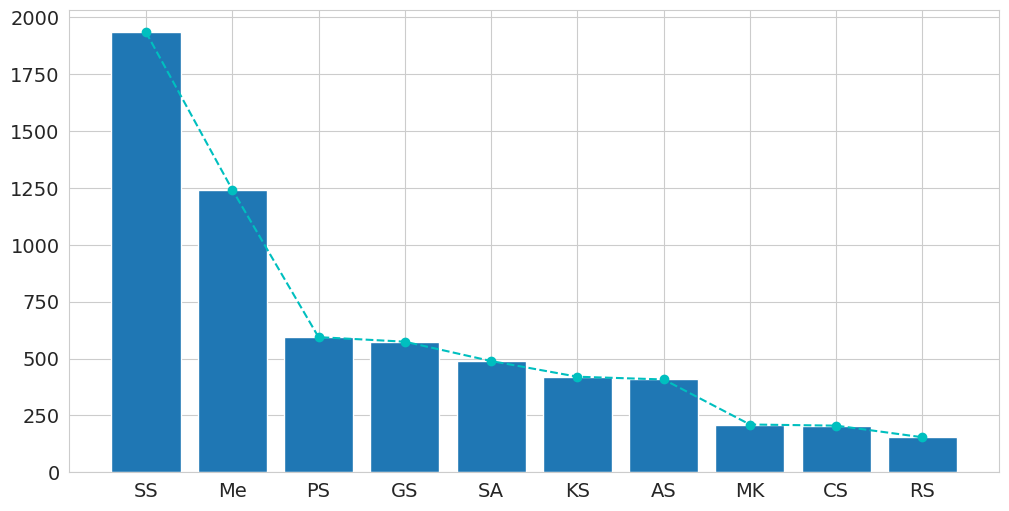

In [94]:
#Plotting a bar chart and line graph together.
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))

plt.bar(top10df.initials, top10df.message)   # basic bar chart
plt.plot(top10df.initials, top10df.message, 'o--c');   # line chart

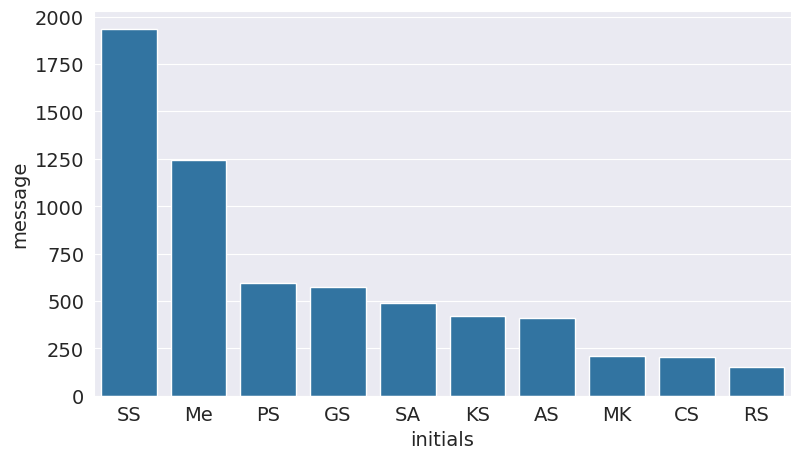

In [95]:
# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")
sns.barplot(x='initials', y='message', data=top10df);

In [96]:
#Maintain consistent colors for each person across all plots
def get_colors_of_certain_order(names_in_certain_order):
    '''the color of a certain person remains the same, no matter the plot'''

    order = list(names_in_certain_order)
    return_list = []

    for name in order:
        return_list.append(color_dict[name])

    return return_list

{'SS': '#F94144',
 'Me': '#F3722C',
 'PS': '#F8961E',
 'GS': '#FDC500',
 'SA': '#F9C74F',
 'KS': '#90BE6D',
 'AS': '#43AA8B',
 'MK': '#577590',
 'CS': '#6D597A',
 'RS': '#003F88'}

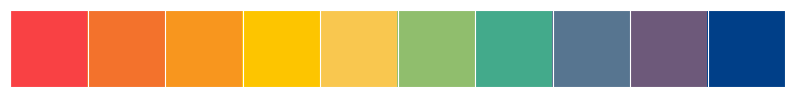

In [97]:
#Nice set of colours for each person
colors = ['#F94144', '#F3722C', '#F8961E', '#FDC500', '#F9C74F', '#90BE6D', '#43AA8B', '#577590', '#6D597A','#003F88']
sns.palplot(colors)    # visualizing the colors' list

names = top10df.initials

color_dict = {}
for name, color in zip(names, colors):
    color_dict[name] = color
color_dict

In [98]:
#finding the average message length of the 10 most active users of the group.
df2['message_length'] = df2['message'].apply(lambda x: len(x))

# Creating another dataframe for average length per user;
avg_msg_lengths = df2.groupby(df2.user)['message_length'].mean().reset_index().sort_values(by = 'message_length', ascending = False)

# Creating helper columns;
top10df['avg_message_length'] = [0] * 10
i, j = 0, 0
while i < 10:
    # Added a check to ensure that the user from top10df exists in avg_msg_lengths
    if top10df['user'][i] in avg_msg_lengths['user'].values:
        # Finding the index of the user in avg_msg_lengths
        j = avg_msg_lengths[avg_msg_lengths['user'] == top10df['user'][i]].index[0]
        top10df['avg_message_length'][i] = avg_msg_lengths['message_length'][j]
        i += 1


# Sorting the average message lengths of the same to 10 active users;
top10df_msg = top10df.sort_values(by = "avg_message_length", ascending=False)

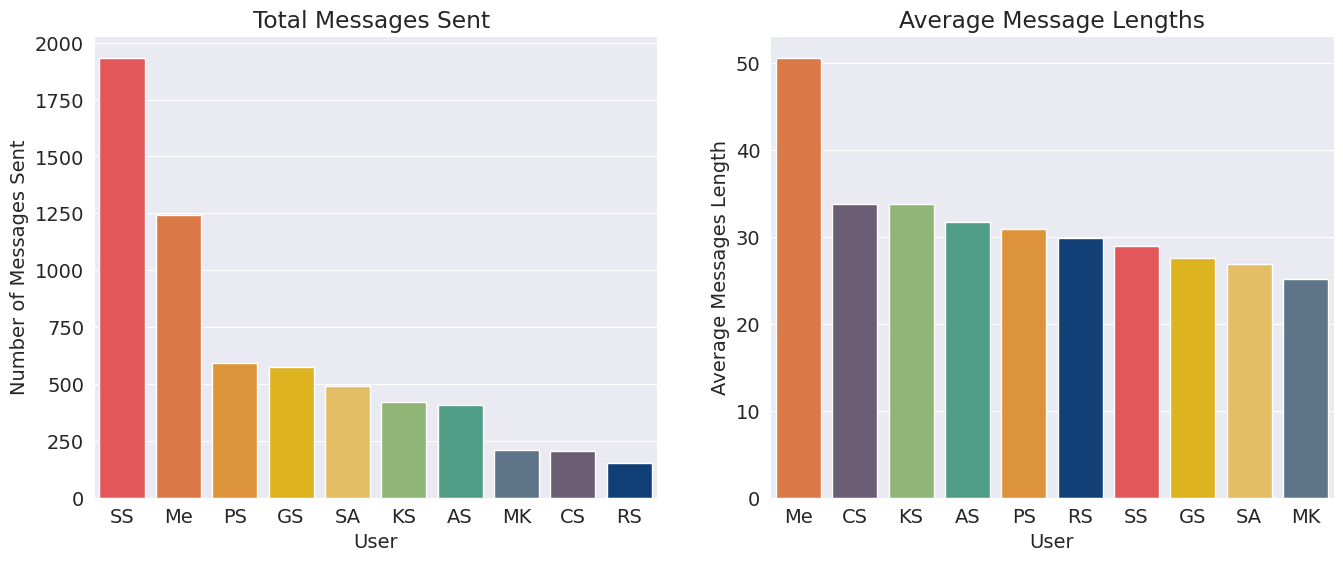

In [99]:
# plotting multiple charts in a grid
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set_style("darkgrid")

# Plot 1 - Countplot of total messages sent
sns.barplot(x='initials', y='message', data=top10df, ax = axes[0], palette=get_colors_of_certain_order(top10df.initials));     # Note: the palette argument;

axes[0].set_title('Total Messages Sent ')
axes[0].set_xlabel('User')
axes[0].set_ylabel('Number of Messages Sent')



# Plot 2 - Barplot of those top 10 users' average message lengths
sns.barplot(x='initials', y='avg_message_length', data=top10df_msg, ax = axes[1], palette = get_colors_of_certain_order(top10df_msg.initials))    # Note: the respective palette argument;

axes[1].set_title('Average Message Lengths')
axes[1].set_xlabel('User');
axes[1].set_ylabel('Average Messages Length');

# Saving the plots
plt.savefig('top10_msg_plots_diff.svg', format = 'svg')

##Top 10 users most sent media

In [100]:
# Using `groupby`, `count` and `sort_values` attributes.
top10media = df[df.message == '<Media omitted> '].groupby('user').count().sort_values(by="message", ascending = False).head(10)

# Dropping unused column;
top10media.drop(columns=['date_time', 'day', 'month', 'year', 'date'], inplace=True)

# Renaming column name for visualization;
top10media.rename(columns={"message": "media_sent"}, inplace=True)

# resetting index;
top10media.reset_index(inplace=True)

top10media['initials'] = ''
for i in range(10):
    name_parts = top10media.user[i].split()
    if len(name_parts) > 1:
        top10media.initials[i] = name_parts[0][0] + name_parts[1][0]
    else:
        top10media.initials[i] = name_parts[0][:2]

top10media.initials[1] = "Me"    # That's me

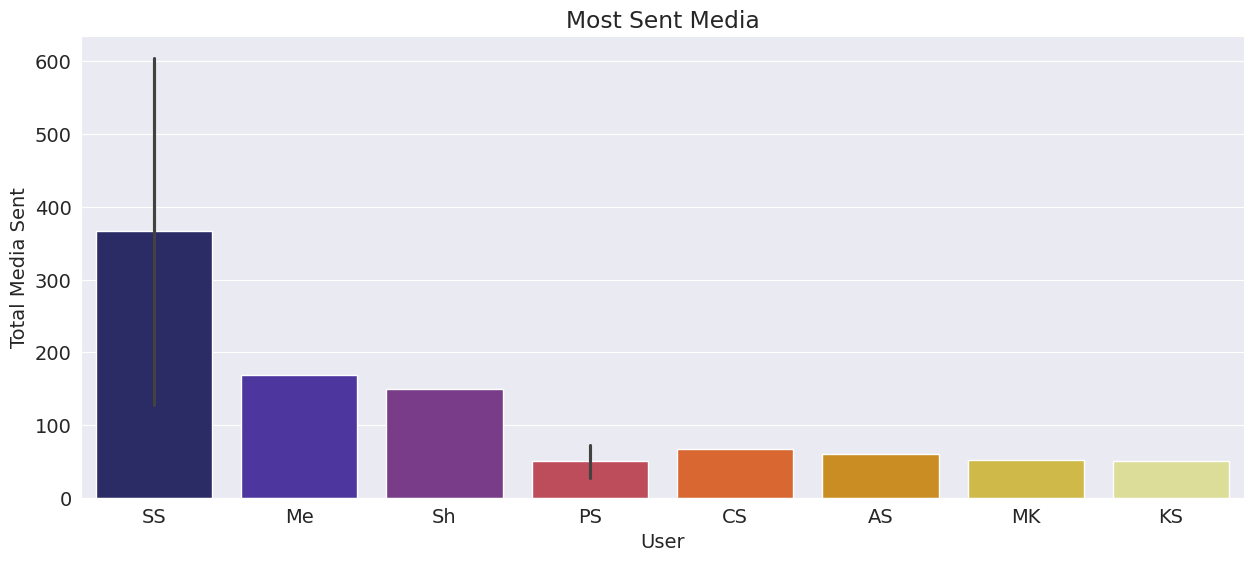

In [101]:
# Increasing the figure size
plt.figure(figsize=(15, 6))

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting a bar graph;
sns.barplot(x='initials', y='media_sent', data=top10media, palette="CMRmap");

plt.title('Most Sent Media')
plt.xlabel('User')
plt.ylabel('Total Media Sent');

# Saving the plots
plt.savefig('top10media.svg', format = 'svg')

##Top 10 most used Emojis

In [102]:
emoji_ctr = Counter()
emojis_list = map(lambda x: ''.join(x.split()), emoji.EMOJI_DATA.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
for idx, row in df.iterrows():
    emojis_found = r.findall(row["message"])
    for emoji_found in emojis_found:
        emoji_ctr[emoji_found] += 1

In [103]:
#Will create another helper column using emoji.demojize("<emoji>"), since emojis will not rendered.
top10emojis = pd.DataFrame()
top10emojis['emoji'] = [''] * 10
top10emojis['emoji_count'] = [0] * 10
top10emojis['emoji_description'] = [''] * 10

i = 0
for item in emoji_ctr.most_common(10):
    # will be using another helper column, since during visualization, the emojis won't be rendered.
    description = emoji.demojize(item[0])[1:-1]

    # appending top 10 data of emojis.  # Loading into a DataFrame.
    top10emojis.emoji[i] = item[0]
    top10emojis.emoji_count[i] = int(item[1])
    top10emojis.emoji_description[i] = description
    i += 1

top10emojis

,emoji,emoji_count,emoji_description
0,😂,473,face_with_tears_of_joy
1,🥳,386,partying_face
2,🤣,317,rolling_on_the_floor_laughing
3,🎉,179,party_popper
4,🔥,111,fire
5,❤️,74,red_heart
6,🥲,63,smiling_face_with_tear
7,🚨,58,police_car_light
8,🎂,56,birthday_cake
9,✨,52,sparkles


##Which Emoji is the most used in the chat?

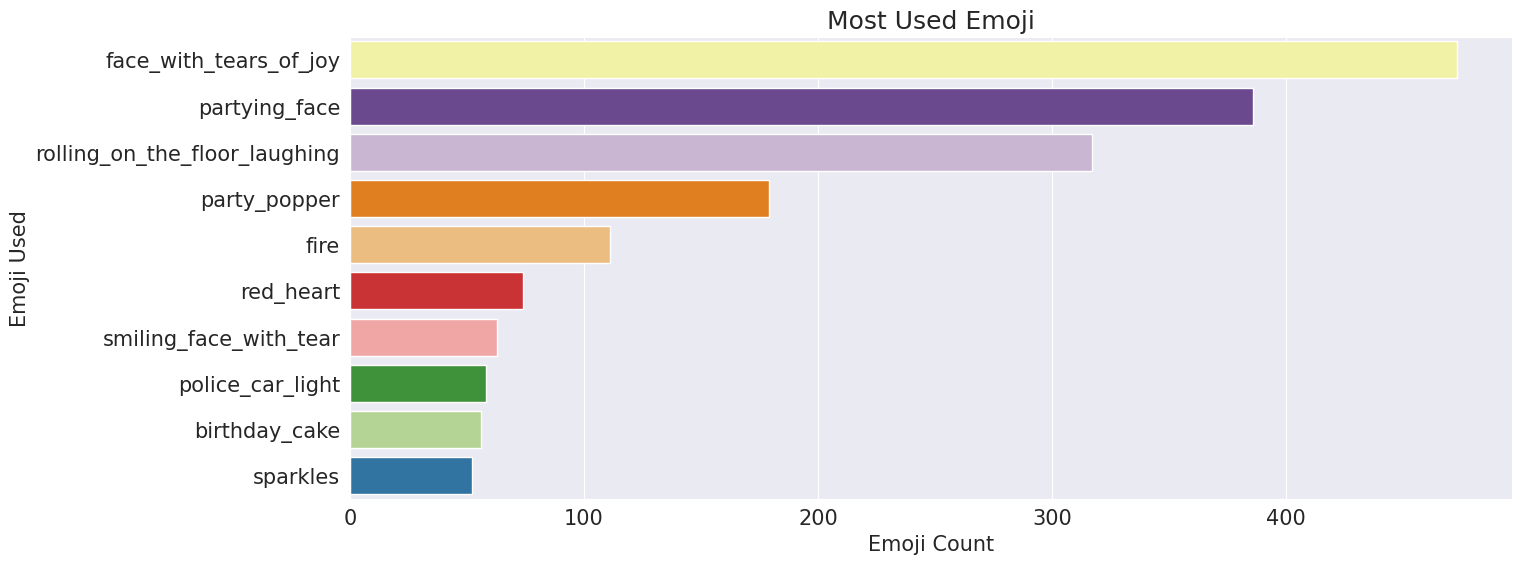

In [104]:
# Increasing the figure size
plt.figure(figsize=(15, 6))

# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 15

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting;
sns.barplot(x=top10emojis.emoji_count, y=top10emojis.emoji_description, palette = "Paired_r", data=top10emojis)

plt.title('Most Used Emoji')
plt.xlabel('Emoji Count')
plt.ylabel('Emoji Used');

# Saving the plots
plt.savefig('top10emoji.svg', format = 'svg')

##Which hour of the day are most messages exchanged?

In [105]:
df3 = df.copy()
df3['message_count'] = [1] * df.shape[0]    # helper column to keep a count.

df3['hour'] = df3['date_time'].apply(lambda x: x.hour)

grouped_by_time = df3.groupby('hour')['message_count'].sum().reset_index().sort_values(by = 'hour')

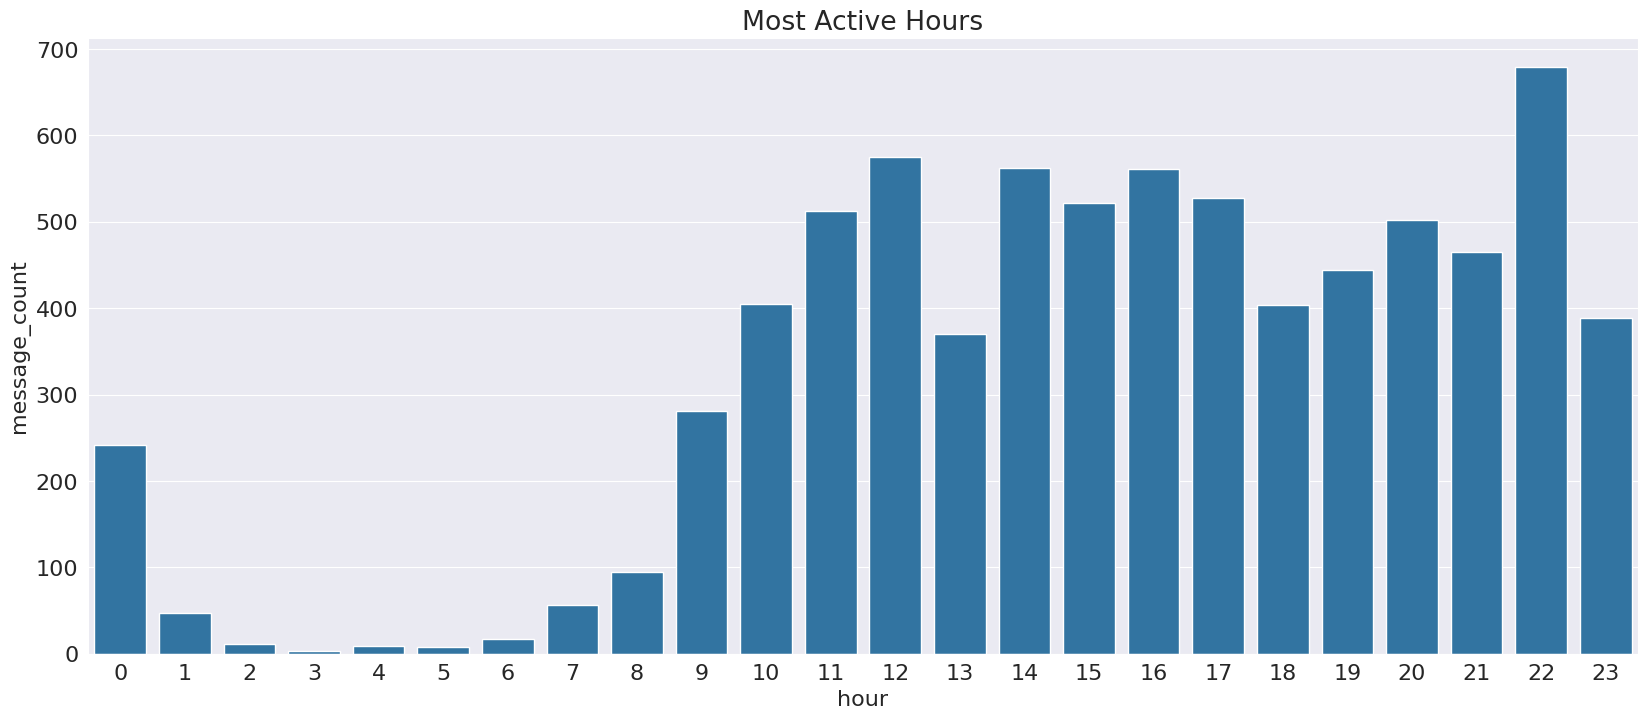

In [106]:
#Which hour of the day are most messages exchanged?
# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (20, 8)

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# PLOT: grouped by hour
sns.barplot(x='hour', y='message_count', data=grouped_by_time)
plt.title('Most Active Hours');

# Saving the plots;
plt.savefig('most_active_hours.svg', format = 'svg')

##Plotting grouped by day and respective group by month simultaneously

In [107]:
# specific `order` to be printed in;
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# grouping by day;
grouped_by_day = df3.groupby('day')['message_count'].sum().reset_index()[['day', 'message_count']]


# specific `order` to be printed in;
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']   # added all months
# grouping by month;
grouped_by_month = df3.groupby('month')['message_count'].sum().reset_index()[['month', 'message_count']]

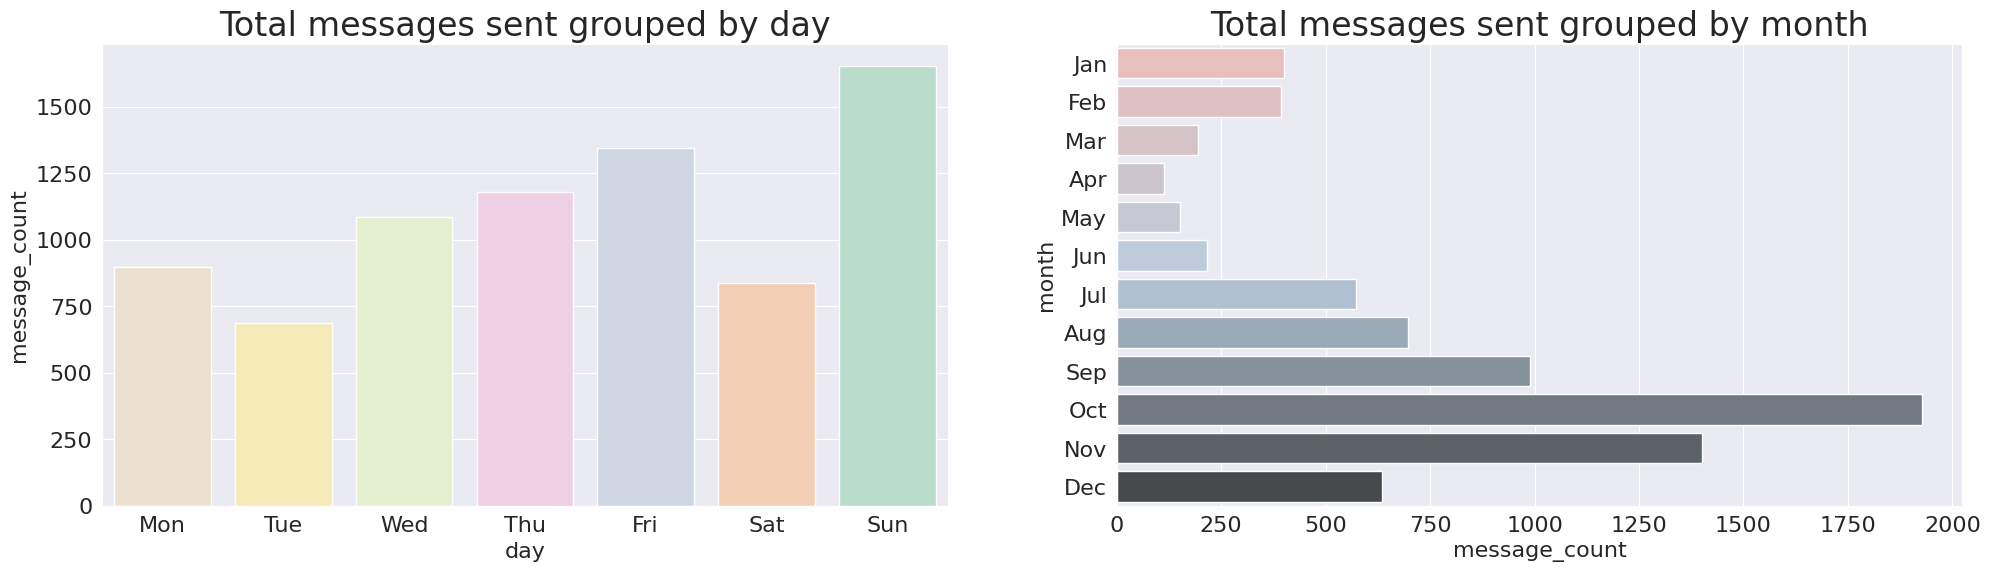

In [108]:
fig, axs = plt.subplots(1, 2, figsize = (24, 6))

# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 20

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting;

# PLOT 1: Messages grouped by weekday
sns.barplot(x='day', y='message_count', data=grouped_by_day, order=days, ax = axs[0], palette='Pastel2_r')
axs[0].set_title('Total messages sent grouped by day')

# PLOT 2: Messages grouped by months
sns.barplot(y='month', x='message_count', data=grouped_by_month, order = months, ax = axs[1], palette='Pastel1_d')
axs[1].set_title('Total messages sent grouped by month');

# Saving the plots;
plt.savefig('days_and_month.svg', format = 'svg')

##Most used words in the chat.

In [109]:
comment_words = ' '

# stopwords --> Words to be avoided while forming the WordCloud,
# removed group_notifications like 'joined', 'deleted';
# removed really common words like "yeah" and "okay".
stopwords = STOPWORDS.update(['group', 'link', 'invite', 'joined', 'message', 'deleted', 'yeah', 'hai', 'yes', 'okay', 'ok', 'will', 'use', 'using', 'one', 'know', 'guy', 'group', 'media', 'omitted'])


# iterate through the DataFrame.
for val in df3.message.values:

    # typecaste each val to string.
    val = str(val)

    # split the value.
    tokens = val.split()

    # Converts each token into lowercase.
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    for words in tokens:
        comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 600, height = 600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 8).generate(comment_words)

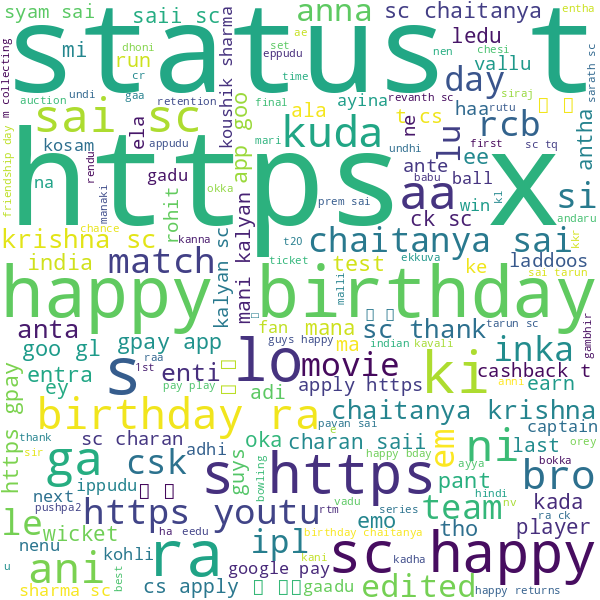

In [110]:
wordcloud.to_image()